This notebook just contains quick tests of our code snippets in a si;ple case with Gaussian correlated noise.

In [1]:
%matplotlib inline

In [2]:
from lsst.daf.persistence import Butler
import lsst.geom as geom
import lsst.afw.math as afwMath
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom
import lsst.meas.algorithms as measAlg

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Morgadditions
import time
import sys
sys.path.append('/project/mschmitz/repos/RaulModelPrototyping')
import helperFuncs as hf
import pandas as pd

In [3]:
plt.rcParams['figure.figsize'] = 8,8
cmap = 'PuOr' # colormap; diverging is best for looking at noise

## Adapting Arun's local cov code
Select how far to compute the covariance for (in both directions, for both axes):

In [4]:
howFar = 3
nbNoiseReals = 10000
printCheckpoints = True

Make dummy covariance matrix:

In [5]:
dataSize = 5,5
nbPix = np.prod(dataSize)
mean = np.zeros(nbPix)

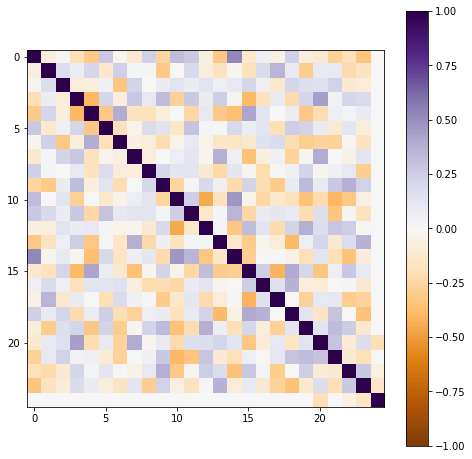

In [6]:
truCov = np.eye(nbPix, nbPix)
np.random.seed(121)
for i in range(nbPix):
    for j in range(i+1,nbPix):
        truCov[i,j] = (np.random.rand(1) - .5)
        truCov[j,i] = truCov[i,j]
truCov = truCov.T.dot(truCov)
# I do want some uncorrelated entries:
truCov[-1,:-5] = 0
truCov[:-5,-1] = 0
# unit variance
truCov /= np.max(truCov)

for j in range(nbPix):
    truCov[j,j] = 1

plt.imshow(truCov, cmap=cmap, interpolation='Nearest', vmin=-1, vmax=1)
plt.colorbar()

In [7]:
covariances = np.zeros((*(dataSize),
                    2*howFar+1, 2*howFar+1)) 
print(covariances.shape, covariances.size)

(5, 5, 7, 7) 1225


Make nosie realizations and compute covariance estimator on each:

In [8]:
start = time.time()
for j in range(nbNoiseReals):
    startReal = time.time()
    noiseReal = np.random.multivariate_normal(mean, truCov, 1)[0].reshape(dataSize)
    startCovComp = time.time()
    if printCheckpoints and not j%500:
        print(' > Noise realization {} generated in {}s'.format(
              j, startCovComp-startReal))
    for xidx,dx in enumerate(range(-howFar,howFar+1)):
        noiseShiftx = np.roll(noiseReal, shift=dx, axis=1)
        for yidx,dy in enumerate(range(-howFar,howFar+1)):
            noiseShiftxy = np.roll(noiseShiftx, shift=dy, axis=0)
            covariances[:,:,xidx,yidx] += noiseShiftxy * noiseReal
    if printCheckpoints and not j%500:
        print(' > Cross terms computed in {}s'.format(
              time.time()-startCovComp))
covariances /= (nbNoiseReals - 1)
print('All done in {}s'.format(time.time()-start))

 > Noise realization 0 generated in 0.0007195472717285156s
 > Cross terms computed in 0.001476287841796875s
 > Noise realization 500 generated in 0.0004246234893798828s
 > Cross terms computed in 0.0014433860778808594s
 > Noise realization 1000 generated in 0.00040411949157714844s
 > Cross terms computed in 0.001466989517211914s
 > Noise realization 1500 generated in 0.0004036426544189453s
 > Cross terms computed in 0.001434326171875s
 > Noise realization 2000 generated in 0.00040650367736816406s
 > Cross terms computed in 0.0014178752899169922s
 > Noise realization 2500 generated in 0.0004303455352783203s
 > Cross terms computed in 0.0014009475708007812s
 > Noise realization 3000 generated in 0.0004742145538330078s
 > Cross terms computed in 0.0015568733215332031s
 > Noise realization 3500 generated in 0.00040602684020996094s
 > Cross terms computed in 0.0014119148254394531s
 > Noise realization 4000 generated in 0.0004649162292480469s
 > Cross terms computed in 0.0015225410461425781s

## Test our estimator
For each shift considered, we can access the corresponding entry of the covariance for every single pixel from the last two axes.

For instance, the diagonal corresponds to a shift of $0,0$, ie:

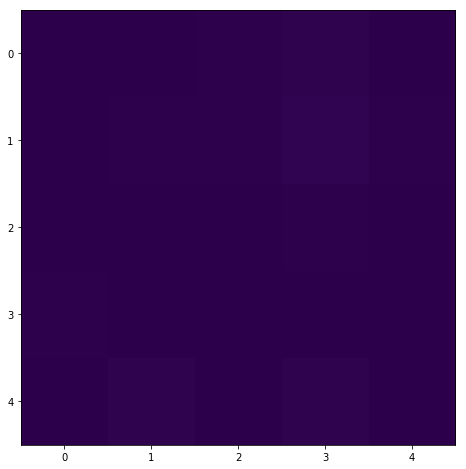

In [9]:
plt.imshow(covariances[:,:,3,3], cmap=cmap, interpolation='Nearest', vmin=-1, vmax=1)

Conversely, we can access the covariance entries with all considered pixels for one given pixel; for instance that last pixel with several 0 covariance counterparts:

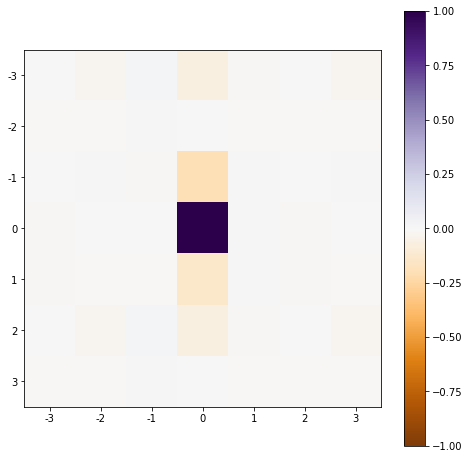

In [10]:
plt.imshow(covariances[-1,-1,:,:], cmap=cmap, interpolation='Nearest', vmin=-1, vmax=1)
plt.colorbar()

# show shifts in the labels
plt.xticks(range(2*howFar + 1), range(-howFar,howFar+1))
plt.yticks(range(2*howFar + 1), range(-howFar,howFar+1))

plt.show()

In [11]:
print(covariances[-1,-1,3:,3])
print(truCov[-1,-5:][::-1])

[ 0.99857504 -0.13869636 -0.06391662  0.00206449]
[ 1.00000000e+00 -1.45608499e-01 -5.98825052e-02  8.19815336e-04
 -1.93509663e-01]


## "Bookkeeping kind of thing"
What Arun wanted to avoid but I don't know, I actually like to look at things that way (probably out of habit because of my OT cost matrices I suppose)

Make a plot with the coordinates of each pixel as x-axis label of the covariance matrix, and y-axis deltas for a given pixel:

In [12]:
pixCoords = []
for i in range(dataSize[0]):
    rowCoords = []
    for j in range(dataSize[0]):
        rowCoords += [str(i)+","+str(j)]
    pixCoords += [rowCoords]
pixCoords = np.array(pixCoords)
print(pixCoords)
pixCoords = pixCoords.flatten()

[['0,0' '0,1' '0,2' '0,3' '0,4']
 ['1,0' '1,1' '1,2' '1,3' '1,4']
 ['2,0' '2,1' '2,2' '2,3' '2,4']
 ['3,0' '3,1' '3,2' '3,3' '3,4']
 ['4,0' '4,1' '4,2' '4,3' '4,4']]


Ok, pick the pixel we'll look at:

In [13]:
pixIdx = 2,3 #4,4

Mapping from covariance entry to "shift":

In [14]:
ylabs = [str(pixIdx[0] - int(coord[0])) +
         str(",") +
         str(pixIdx[1] - int(coord[-1]))
        for coord in pixCoords]
print(ylabs)

['2,3', '2,2', '2,1', '2,0', '2,-1', '1,3', '1,2', '1,1', '1,0', '1,-1', '0,3', '0,2', '0,1', '0,0', '0,-1', '-1,3', '-1,2', '-1,1', '-1,0', '-1,-1', '-2,3', '-2,2', '-2,1', '-2,0', '-2,-1']


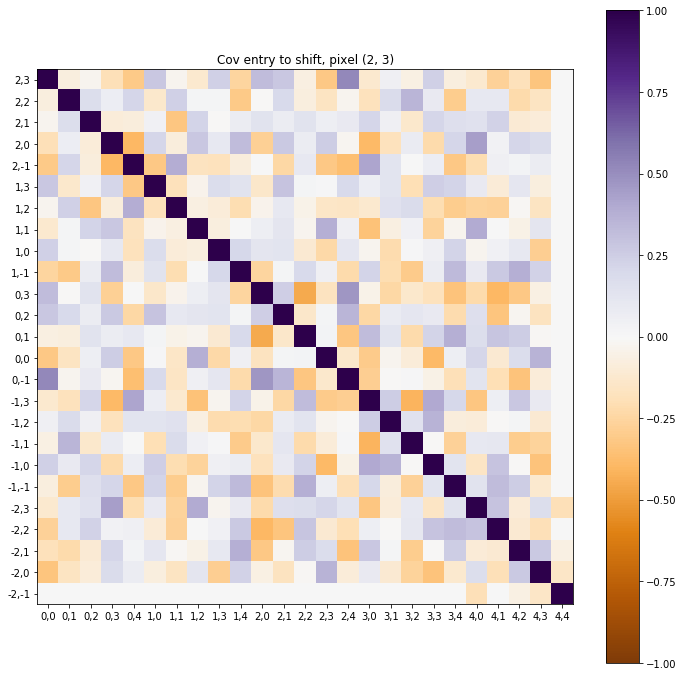

In [15]:
plt.rcParams['figure.figsize'] = 12,12
plt.imshow(truCov, cmap=cmap, interpolation='Nearest', vmin=-1, vmax=1)
plt.xticks(range(nbPix), pixCoords)
plt.yticks(range(nbPix), ylabs)
plt.title('Cov entry to shift, pixel {}'.format(pixIdx))
plt.colorbar()

plt.rcParams['figure.figsize'] = 8,8

And same for those we get from our estimators:

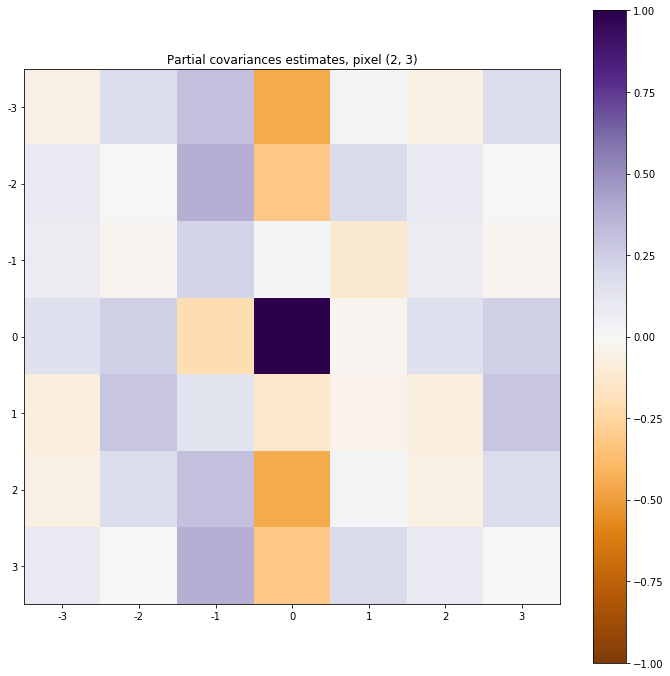

In [16]:
plt.rcParams['figure.figsize'] = 12,12
plt.imshow(covariances[pixIdx[0],pixIdx[0],:,:], cmap=cmap, interpolation='Nearest', vmin=-1, vmax=1)

plt.xticks(range(2*howFar + 1), range(-howFar,howFar+1))
plt.yticks(range(2*howFar + 1), range(-howFar,howFar+1))
plt.title('Partial covariances estimates, pixel {}'.format(pixIdx))
plt.colorbar()

plt.rcParams['figure.figsize'] = 8,8

Annoying to match up, but if you do, they _do_ match.

We need to figure out a way to make visualization less of a hassle, but at least the estimator does what it's supposed to do.